In [1]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt

from sklearn import metrics

from scipy.sparse import csr_matrix

from sklearn import preprocessing
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.keras import models, layers, utils

In [2]:
df = pd.read_csv("data/preprocessed_books.csv")

In [3]:
df

,User-ID,ISBN,Book-Rating,title,author,rating,description,pages,awards,numRatings,...,Adult Fiction,Literature,Mystery Thriller,Crime,Audiobook,Historical,Adventure,Science Fiction,Young Adult,average_price
0,276747,0060517794,9,Little Altars Everywhere,Rebecca Wells,3.57,Little Altars Everywhere is a national best-se...,288,0,28611,...,1,0,0,0,0,1,0,0,0,3.39000
1,276747,0671537458,9,Waiting to Exhale,Terry McMillan,3.98,The story of friendship between four African A...,448,0,14718,...,1,0,0,0,0,0,0,0,0,0.89000
2,276747,0679776818,8,Birdsong: A Novel of Love and War,Sebastian Faulks,4.09,Published to international critical and popula...,483,1,68404,...,0,1,0,0,0,1,0,0,0,3.33000
3,276755,0451166892,5,The Pillars of the Earth,Ken Follett,4.31,Ken Follett is known worldwide as the master o...,976,0,648793,...,0,1,0,0,1,1,0,0,0,6.66651
4,276762,0380711524,5,See Jane Run,Joy Fielding,3.92,What do you do when you don't know who you are...,416,0,8008,...,1,0,1,1,0,0,0,0,0,2.86000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58532,276681,0060938455,9,Fast Food Nation: The Dark Side of the All-Ame...,Eric Schlosser,3.75,Fast food has hastened the malling of our land...,399,1,197560,...,0,0,0,0,0,0,0,0,0,3.09000
58533,276688,0553566040,6,Missing Joseph,Elizabeth George,3.96,Deborah and Simon St. James have taken a holid...,576,0,11641,...,0,1,1,1,0,0,0,0,0,7.51000
58534,276688,0553575104,6,In Pursuit of the Proper Sinner,Elizabeth George,4.10,A theatrical producer shoots himself on the ni...,718,0,12659,...,0,1,1,1,1,0,0,0,0,2.86000
58535,276688,0684804484,10,No Ordinary Time: Franklin and Eleanor Rooseve...,Doris Kearns Goodwin,4.18,"Winner of the Pulitzer for History, No Ordinar...",633,2,40982,...,0,0,0,0,0,1,0,0,0,7.08000


# Rating Creation

We want to combine all rating, award and score information into one metric, so we can evaluate and compare books against each other as accurately as possible.

Let's make the bbeVotes a relative score:

In [4]:
def standardize(series): 
    return 100 * (series - series.min()) / series.max()

In [5]:
df["bbePopularity"] = np.ceil(standardize(df["bbeVotes"]))
df["bbePopularity"]

0         1.0
1         1.0
2         1.0
3        19.0
4         1.0
         ... 
58532     1.0
58533     1.0
58534     1.0
58535     1.0
58536     1.0
Name: bbePopularity, Length: 58537, dtype: float64

Let's transform the rating into percentage:

In [6]:
df["rating"] = standardize(df["rating"] * 100 / 5)
df["rating"]

0        23.6
1        31.8
2        34.0
3        38.4
4        30.6
         ... 
58532    27.2
58533    31.4
58534    34.2
58535    35.8
58536    24.8
Name: rating, Length: 58537, dtype: float64

In [7]:
df["awards"].value_counts()

awards
0     33601
1     11271
2      5454
3      2044
4      1883
5      1374
9       604
6       589
8       539
7       374
13      317
10      156
11      134
12       93
22       47
15       42
16        6
17        3
25        2
14        2
28        1
21        1
Name: count, dtype: int64

We can transform the values into ordinal categories:

In [8]:
# Define the bin edges
bins = [0, 0.99, 4.99, 9.99, 29.99]

# Define the labels for the bins
labels = [15, 60, 85, 100]

# Categorize the numeric column into ordinal categories
df["awards"] = pd.cut(df["awards"], bins=bins, labels=labels, right=False).astype(int)

In [9]:
df["awards"].value_counts()

awards
15     33601
60     20652
85      3480
100      804
Name: count, dtype: int64

We will evaluate the books (in percentage) based on the following formula:

- 30% - liked percentage
- 35% - rating
- 15% - BBE popularity
- 20% - awards

In [10]:
df["overall_rating"] = standardize(df["likedPercent"] * 30 + df["rating"] * 35 + df["bbePopularity"] * 15 + df["awards"] * 20)

[]

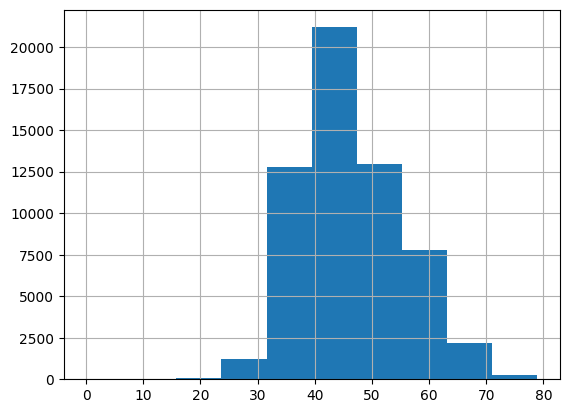

In [11]:
df["overall_rating"].hist()
plt.plot()

In [12]:
book_df = df.copy()
book_df = book_df.drop(columns=["User-ID", "Book-Rating"])
book_df.drop_duplicates(inplace=True)
book_df.reset_index(inplace=True, drop=True)

In [13]:
book_df

,ISBN,title,author,rating,description,pages,awards,numRatings,likedPercent,bbeScore,...,Mystery Thriller,Crime,Audiobook,Historical,Adventure,Science Fiction,Young Adult,average_price,bbePopularity,overall_rating
0,0060517794,Little Altars Everywhere,Rebecca Wells,23.6,Little Altars Everywhere is a national best-se...,288,15,28611,88.0,476,...,0,0,0,1,0,0,0,3.390000,1.0,33.768873
1,0671537458,Waiting to Exhale,Terry McMillan,31.8,The story of friendship between four African A...,448,15,14718,94.0,95,...,0,0,0,0,0,0,0,0.890000,1.0,40.548780
2,0679776818,Birdsong: A Novel of Love and War,Sebastian Faulks,34.0,Published to international critical and popula...,483,60,68404,93.0,6741,...,0,0,0,1,0,0,0,3.330000,1.0,54.297329
3,0451166892,The Pillars of the Earth,Ken Follett,38.4,Ken Follett is known worldwide as the master o...,976,15,648793,95.0,392260,...,0,0,1,1,0,0,0,6.666510,19.0,48.257840
4,0380711524,See Jane Run,Joy Fielding,30.6,What do you do when you don't know who you are...,416,15,8008,93.0,173,...,1,1,0,0,0,0,0,2.860000,1.0,39.503484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7613,0689843240,The Great Good Thing,Roderick Townley,30.4,"Sylvie had an amazing life, but she didn't get...",224,15,2352,91.0,79,...,0,0,0,0,1,1,1,2.360000,1.0,38.530778
7614,0446356050,Promises to Keep,Ann Tatlock,31.0,Eleven-year-old Roz (Rosalind) Anthony and her...,348,15,1997,95.0,87,...,0,0,0,1,0,0,0,4.230000,1.0,40.577816
7615,0425185508,Picture Perfect,Camille Dixon,24.2,"On the outside, Devin Thompson looks like he h...",308,15,308,86.0,94,...,0,0,0,0,0,0,0,7.125528,1.0,33.202671
7616,0803727356,The River Between Us,Richard Peck,27.6,The year is 1861. Civil war is imminent and Ti...,164,60,4340,91.0,85,...,0,0,0,1,0,0,1,7.500000,1.0,50.174216


[]

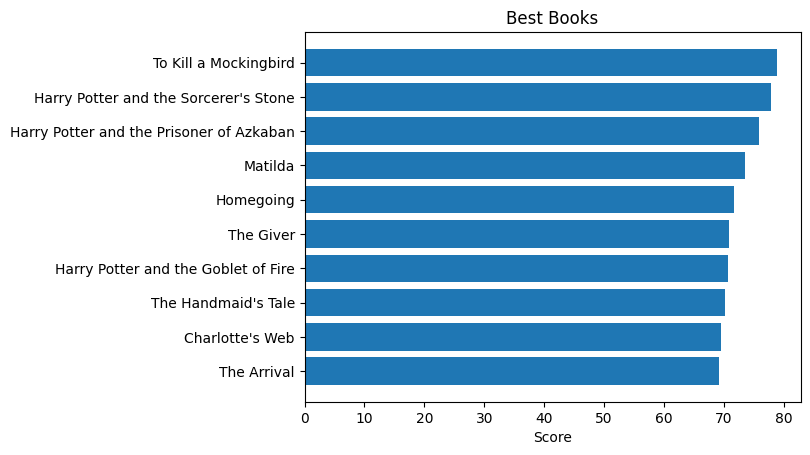

In [14]:
plt.barh(
    book_df.sort_values("overall_rating", ascending=False)["title"].head(10),
    book_df.sort_values("overall_rating", ascending=False)["overall_rating"].head(10), 
    align="center"
)
plt.gca().invert_yaxis()
plt.xlabel("Score")
plt.title("Best Books")
plt.plot()

# Content Based Filtering

## TF-IDF

In [15]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_features=30_000, dtype=np.float32)
book_df["description"] = book_df["description"].fillna("")
tfidf_matrix = tfidf_vectorizer.fit_transform(book_df["description"])
tfidf_matrix.shape

(7618, 30000)

In [16]:
title_to_index = pd.Series(book_df.index, index=book_df["title"]).drop_duplicates()

In [17]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [18]:
def get_recommendations(title, similarity):
    idx = title_to_index[title]
    sim_scores = list(enumerate(similarity[idx]))
    sim_scores.sort(key=lambda X: X[1], reverse=True)
    sim_scores = sim_scores[1:11]
    indices = [i[0] for i in sim_scores]
    return book_df["title"].iloc[indices]

In [19]:
get_recommendations("Harry Potter and the Prisoner of Azkaban", cosine_sim)

2561              Harry Potter and the Chamber of Secrets
5510                Harry Potter and the Sorcerer's Stone
3603                  Harry Potter and the Goblet of Fire
6878    Harry Potter Schoolbooks Box Set: Two Classic ...
3999                                               Pronto
3305                                    Star in the Storm
6064                                        Into the Blue
2723              Fantastic Beasts and Where to Find Them
2449                                          Blood Rites
4554                               Absolutely, Positively
Name: title, dtype: object

In [20]:
genres = ["Fiction", "Novels", "Adult", "Mystery", "Contemporary", "Thriller", "Romance",
          "Classics", "Suspense", "Fantasy", "Historical Fiction", "Adult Fiction", "Literature", "Mystery Thriller",
          "Crime", "Audiobook", "Historical", "Adventure", "Science Fiction", "Young Adult"]

In [21]:
def get_genres(row):
    current_genres = ""
    for genre in genres:
        if row[genre] == 1:
            current_genres += genre + ", "
    return current_genres

In [22]:
def get_characteristics(x):
    return get_genres(x) + x["author"] + x["description"]

book_df["combined_characteristics"] = book_df.apply(get_characteristics, axis=1)

In [23]:
book_df

,ISBN,title,author,rating,description,pages,awards,numRatings,likedPercent,bbeScore,...,Crime,Audiobook,Historical,Adventure,Science Fiction,Young Adult,average_price,bbePopularity,overall_rating,combined_characteristics
0,0060517794,Little Altars Everywhere,Rebecca Wells,23.6,Little Altars Everywhere is a national best-se...,288,15,28611,88.0,476,...,0,0,1,0,0,0,3.390000,1.0,33.768873,"Fiction, Novels, Adult, Contemporary, Historic..."
1,0671537458,Waiting to Exhale,Terry McMillan,31.8,The story of friendship between four African A...,448,15,14718,94.0,95,...,0,0,0,0,0,0,0.890000,1.0,40.548780,"Fiction, Novels, Adult, Contemporary, Romance,..."
2,0679776818,Birdsong: A Novel of Love and War,Sebastian Faulks,34.0,Published to international critical and popula...,483,60,68404,93.0,6741,...,0,0,1,0,0,0,3.330000,1.0,54.297329,"Fiction, Novels, Romance, Classics, Historical..."
3,0451166892,The Pillars of the Earth,Ken Follett,38.4,Ken Follett is known worldwide as the master o...,976,15,648793,95.0,392260,...,0,1,1,0,0,0,6.666510,19.0,48.257840,"Fiction, Novels, Adult, Classics, Fantasy, His..."
4,0380711524,See Jane Run,Joy Fielding,30.6,What do you do when you don't know who you are...,416,15,8008,93.0,173,...,1,0,0,0,0,0,2.860000,1.0,39.503484,"Fiction, Adult, Mystery, Contemporary, Thrille..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7613,0689843240,The Great Good Thing,Roderick Townley,30.4,"Sylvie had an amazing life, but she didn't get...",224,15,2352,91.0,79,...,0,0,0,1,1,1,2.360000,1.0,38.530778,"Fiction, Adult, Fantasy, Adventure, Science Fi..."
7614,0446356050,Promises to Keep,Ann Tatlock,31.0,Eleven-year-old Roz (Rosalind) Anthony and her...,348,15,1997,95.0,87,...,0,0,1,0,0,0,4.230000,1.0,40.577816,"Fiction, Mystery, Contemporary, Historical Fic..."
7615,0425185508,Picture Perfect,Camille Dixon,24.2,"On the outside, Devin Thompson looks like he h...",308,15,308,86.0,94,...,0,0,0,0,0,0,7.125528,1.0,33.202671,"Adult, Contemporary, Romance, Camille Dixon On..."
7616,0803727356,The River Between Us,Richard Peck,27.6,The year is 1861. Civil war is imminent and Ti...,164,60,4340,91.0,85,...,0,0,1,0,0,1,7.500000,1.0,50.174216,"Fiction, Adult, Historical Fiction, Historical..."


## Count Vectorizer

In [24]:
count_vectorizer = CountVectorizer(stop_words="english")
count_matrix = count_vectorizer.fit_transform(book_df["combined_characteristics"])

In [25]:
count_sim = linear_kernel(count_matrix, count_matrix)

In [26]:
get_recommendations("Harry Potter and the Prisoner of Azkaban", count_sim)

5510                Harry Potter and the Sorcerer's Stone
2561              Harry Potter and the Chamber of Secrets
6878    Harry Potter Schoolbooks Box Set: Two Classic ...
422                                           The Bottoms
7578    Leadership and the New Science: Discovering Or...
1541                                             Still Me
3603                  Harry Potter and the Goblet of Fire
3999                                               Pronto
6321                         The Complete Sherlock Holmes
2723              Fantastic Beasts and Where to Find Them
Name: title, dtype: object

# Collaborative Filtering

In [27]:
isbn_index_df = pd.DataFrame({"ISBN": df["ISBN"].unique(), "Index": range(len(df["ISBN"].unique()))})
df = df.merge(isbn_index_df, on="ISBN")
df = df.drop(columns="ISBN").rename(columns={"Index": "ISBN"})

user_index_df = pd.DataFrame({"User-ID": df["User-ID"].unique(), "Index": range(len(df["User-ID"].unique()))})
df = df.merge(user_index_df, on="User-ID")
df = df.drop(columns="User-ID").rename(columns={"Index": "User-ID"})

In [28]:
df.head()

,Book-Rating,title,author,rating,description,pages,awards,numRatings,likedPercent,bbeScore,...,Audiobook,Historical,Adventure,Science Fiction,Young Adult,average_price,bbePopularity,overall_rating,ISBN,User-ID
0,9,Little Altars Everywhere,Rebecca Wells,23.6,Little Altars Everywhere is a national best-se...,288,15,28611,88.0,476,...,0,1,0,0,0,3.39,1.0,33.768873,0,0
1,9,Waiting to Exhale,Terry McMillan,31.8,The story of friendship between four African A...,448,15,14718,94.0,95,...,0,0,0,0,0,0.89,1.0,40.548780,1,0
2,8,Birdsong: A Novel of Love and War,Sebastian Faulks,34.0,Published to international critical and popula...,483,60,68404,93.0,6741,...,0,1,0,0,0,3.33,1.0,54.297329,2,0
3,7,Little Altars Everywhere,Rebecca Wells,23.6,Little Altars Everywhere is a national best-se...,288,15,28611,88.0,476,...,0,1,0,0,0,3.39,1.0,33.768873,0,1
4,9,The Bonesetter's Daughter,Amy Tan,31.8,"Ruth Young and her widowed mother, LuLing, hav...",387,60,121064,96.0,1629,...,0,1,0,0,0,3.16,1.0,54.486063,217,1


In [29]:
rating_df = df.pivot(index='User-ID', columns='ISBN', values='Book-Rating')

rating_df = pd.DataFrame.sparse.from_spmatrix(
    csr_matrix(rating_df.values), 
    index=rating_df.index, 
    columns=rating_df.columns
)

rating_df

ISBN,0,1,2,3,4,5,6,7,8,9,...,7308,7309,7310,7311,7312,7313,7314,7315,7316,7317
User-ID,,,,,,,,,,,,,,,,,,,,,
0,9.0,9.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
rating_df = pd.DataFrame(
    preprocessing.MinMaxScaler(feature_range=(0.5,1)).fit_transform(rating_df.values), 
    columns=rating_df.columns, 
    index=rating_df.index
)

rating_df

ISBN,0,1,2,3,4,5,6,7,8,9,...,7308,7309,7310,7311,7312,7313,7314,7315,7316,7317
User-ID,,,,,,,,,,,,,,,,,,,,,
0,0.9,1.0,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
num_users = rating_df.shape[0]
num_users

22539

In [32]:
num_books = rating_df.shape[1]
num_books

7318

In [33]:
split = int(0.8 * rating_df.shape[1])
dtf_train = rating_df.loc[:, :split-1]
dtf_test = rating_df.loc[:, split:]

train = dtf_train.stack(dropna=True).reset_index().rename(columns={0:"y"})
test = dtf_test.stack(dropna=True).reset_index().rename(columns={0:"y"})

In [34]:
train

,User-ID,ISBN,y
0,0,0,0.900000
1,0,1,1.000000
2,0,2,0.800000
3,1,0,0.700000
4,1,217,0.928571
...,...,...,...
56522,22022,5850,0.833333
56523,22023,5851,1.000000
56524,22024,5852,1.000000
56525,22025,5853,0.700000


In [35]:
test

,User-ID,ISBN,y
0,13,5861,0.500000
1,13,5862,0.500000
2,13,5863,0.833333
3,13,5864,0.500000
4,13,5865,0.500000
...,...,...,...
2005,22534,7297,0.500000
2006,22535,7304,0.500000
2007,22536,7305,0.500000
2008,22537,7306,0.500000


In [36]:
embeddings_size = 30

# Users (1,embedding_size)
users_in = layers.Input(name="users_in", shape=(1,))
users_emb = layers.Embedding(name="users_emb", input_dim=num_users, output_dim=embeddings_size)(users_in)
users = layers.Reshape(name="users", target_shape=(embeddings_size,))(users_emb)

# Products (1,embedding_size)
books_in = layers.Input(name="books_in", shape=(1,))
books_emb = layers.Embedding(name="books_emb", input_dim=num_books, output_dim=embeddings_size)(books_in)
books = layers.Reshape(name='books', target_shape=(embeddings_size,))(books_emb)

In [37]:
# Product (1)
xx = layers.Dot(name='xx', normalize=True, axes=1)([users, books])

# Predict ratings (1)
y_out = layers.Dense(name="rating_pred", units=1, activation='linear')(xx)

# Compile
model_cf = models.Model(inputs=[users_in, books_in], outputs=y_out, name="CollaborativeFiltering")
model_cf.compile(optimizer='adam', loss='mean_absolute_error')
model_cf.summary()

Model: "CollaborativeFiltering"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 users_in (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 books_in (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 users_emb (Embedding)       (None, 1, 30)                676170    ['users_in[0][0]']            
                                                                                                  
 books_emb (Embedding)       (None, 1, 30)                219540    ['books_in[0][0]']            
                                                                             

In [38]:
history_cf = model_cf.fit(x=[train["User-ID"], train["ISBN"]], y=train["y"], epochs=100, batch_size=256, shuffle=True, verbose=1, validation_split=0.3)
model_cf = history_cf.model

Epoch 1/100
155/155 [==============================] - 1s 5ms/step - loss: 0.7343 - val_loss: 0.6295
Epoch 2/100
155/155 [==============================] - 1s 4ms/step - loss: 0.5217 - val_loss: 0.4740
Epoch 3/100
155/155 [==============================] - 1s 4ms/step - loss: 0.2424 - val_loss: 0.3672
Epoch 4/100
155/155 [==============================] - 1s 4ms/step - loss: 0.1098 - val_loss: 0.3436
Epoch 5/100
155/155 [==============================] - 1s 4ms/step - loss: 0.0798 - val_loss: 0.3285
Epoch 6/100
155/155 [==============================] - 1s 4ms/step - loss: 0.0634 - val_loss: 0.3195
Epoch 7/100
155/155 [==============================] - 1s 4ms/step - loss: 0.0555 - val_loss: 0.3081
Epoch 8/100
155/155 [==============================] - 1s 4ms/step - loss: 0.0486 - val_loss: 0.3020
Epoch 9/100
155/155 [==============================] - 1s 4ms/step - loss: 0.0446 - val_loss: 0.2925
Epoch 10/100
155/155 [==============================] - 1s 4ms/step - loss: 0.0410 - val_lo

In [39]:
test["yhat"] = model_cf.predict([test["User-ID"], test["ISBN"]])
test

63/63 [==============================] - 0s 565us/step


,User-ID,ISBN,y,yhat
0,13,5861,0.500000,0.791038
1,13,5862,0.500000,0.675272
2,13,5863,0.833333,0.666677
3,13,5864,0.500000,0.766780
4,13,5865,0.500000,0.759174
...,...,...,...,...
2005,22534,7297,0.500000,0.642287
2006,22535,7304,0.500000,0.773124
2007,22536,7305,0.500000,0.697468
2008,22537,7306,0.500000,0.685277


In [40]:
y_test = test["y"]
predicted = test["yhat"]

print("Mean Absolute Percent Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2))+"%")

Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.31%


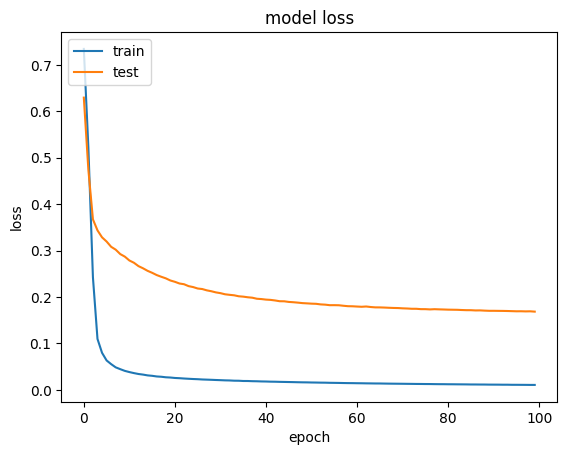

In [41]:
plt.plot(history_cf.history['loss'])
plt.plot(history_cf.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##  Neural Collaborative Filtering

In [43]:
users_in = layers.Input(name="cf_users_in", shape=(1,))
cf_users_emb = layers.Embedding(name="cf_users_emb", input_dim=num_users, output_dim=embeddings_size)(users_in)
cf_users = layers.Reshape(name='cf_users', target_shape=(embeddings_size,))(cf_users_emb)

books_in = layers.Input(name="cf_books_in", shape=(1,))
cf_books_emb = layers.Embedding(name="cf_books_emb", input_dim=num_books, output_dim=embeddings_size)(books_in)
cf_books = layers.Reshape(name='cf_books', target_shape=(embeddings_size,))(cf_books_emb)

cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_users, cf_books])

nn_users_emb = layers.Embedding(name="nn_users_emb", input_dim=num_users, output_dim=embeddings_size)(users_in)
nn_users = layers.Reshape(name='nn_users', target_shape=(embeddings_size,))(nn_users_emb)

nn_books_emb = layers.Embedding(name="nn_books_emb", input_dim=num_books, output_dim=embeddings_size)(books_in)
nn_books = layers.Reshape(name='nn_books', target_shape=(embeddings_size,))(nn_books_emb)

nn_xx = layers.Concatenate()([nn_users, nn_books])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

y_out = layers.Concatenate()([cf_xx, nn_xx])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

In [44]:
# Compile
model_ncf = models.Model(inputs=[users_in, books_in], outputs=y_out, name="Neural_CollaborativeFiltering")
model_ncf.compile(optimizer='adam', loss='mean_absolute_error')
model_ncf.summary()

Model: "Neural_CollaborativeFiltering"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 cf_users_in (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 cf_books_in (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 nn_users_emb (Embedding)    (None, 1, 30)                676170    ['cf_users_in[0][0]']         
                                                                                                  
 nn_books_emb (Embedding)    (None, 1, 30)                219540    ['cf_books_in[0][0]']         
                                                                      

In [45]:
history_ncf = model_ncf.fit(x=[train["User-ID"], train["ISBN"]], y=train["y"], epochs=100, batch_size=256, shuffle=True, verbose=1, validation_split=0.3)
model_ncf = history_ncf.model

Epoch 1/100
155/155 [==============================] - 2s 7ms/step - loss: 0.3376 - val_loss: 0.2192
Epoch 2/100
155/155 [==============================] - 1s 7ms/step - loss: 0.1127 - val_loss: 0.1819
Epoch 3/100
155/155 [==============================] - 1s 7ms/step - loss: 0.0822 - val_loss: 0.1770
Epoch 4/100
155/155 [==============================] - 1s 7ms/step - loss: 0.0654 - val_loss: 0.1688
Epoch 5/100
155/155 [==============================] - 1s 7ms/step - loss: 0.0558 - val_loss: 0.1653
Epoch 6/100
155/155 [==============================] - 1s 7ms/step - loss: 0.0479 - val_loss: 0.1631
Epoch 7/100
155/155 [==============================] - 1s 7ms/step - loss: 0.0431 - val_loss: 0.1624
Epoch 8/100
155/155 [==============================] - 1s 7ms/step - loss: 0.0392 - val_loss: 0.1594
Epoch 9/100
155/155 [==============================] - 1s 7ms/step - loss: 0.0364 - val_loss: 0.1621
Epoch 10/100
155/155 [==============================] - 1s 7ms/step - loss: 0.0341 - val_lo

In [46]:
test["yhat"] = model_ncf.predict([test["User-ID"], test["ISBN"]])
test

63/63 [==============================] - 0s 565us/step


,User-ID,ISBN,y,yhat
0,13,5861,0.500000,0.744183
1,13,5862,0.500000,0.869988
2,13,5863,0.833333,0.778331
3,13,5864,0.500000,0.818002
4,13,5865,0.500000,0.836119
...,...,...,...,...
2005,22534,7297,0.500000,0.881106
2006,22535,7304,0.500000,0.673968
2007,22536,7305,0.500000,0.767887
2008,22537,7306,0.500000,0.866422


In [47]:
y_test = test["y"]
predicted = test["yhat"]

print("Mean Absolute Percent Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2))+"%")

Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.32%


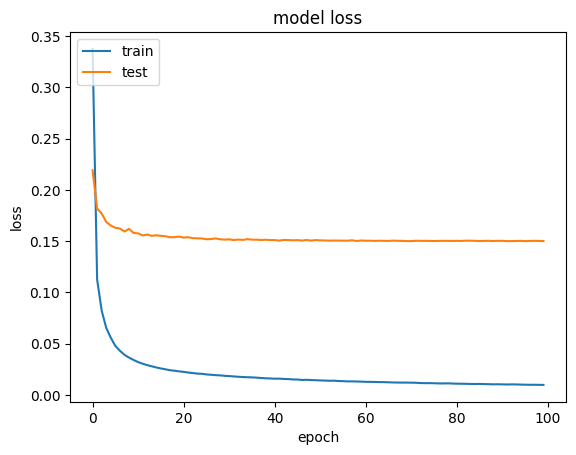

In [48]:
plt.plot(history_ncf.history['loss'])
plt.plot(history_ncf.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Extra Feature Model

In [50]:
train = train.merge(df[genres], how="left", left_on="ISBN", right_index=True)
train

,User-ID,ISBN,y,Fiction,Novels,Adult,Mystery,Contemporary,Thriller,Romance,...,Historical Fiction,Adult Fiction,Literature,Mystery Thriller,Crime,Audiobook,Historical,Adventure,Science Fiction,Young Adult
0,0,0,0.900000,1,1,1,0,1,0,0,...,1,1,0,0,0,0,1,0,0,0
1,0,1,1.000000,1,1,1,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0
2,0,2,0.800000,1,1,0,0,0,0,1,...,1,0,1,0,0,0,1,0,0,0
3,1,0,0.700000,1,1,1,0,1,0,0,...,1,1,0,0,0,0,1,0,0,0
4,1,217,0.928571,1,1,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56522,22022,5850,0.833333,1,1,0,0,1,0,0,...,1,0,1,0,0,0,1,0,0,0
56523,22023,5851,1.000000,1,1,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
56524,22024,5852,1.000000,1,1,1,1,1,0,0,...,0,1,1,0,0,0,0,0,0,0
56525,22025,5853,0.700000,1,1,1,0,0,0,0,...,1,1,0,0,0,0,1,0,0,0


In [51]:
test = test.merge(df[genres], how="left", left_on="ISBN", right_index=True)
test

,User-ID,ISBN,y,yhat,Fiction,Novels,Adult,Mystery,Contemporary,Thriller,...,Historical Fiction,Adult Fiction,Literature,Mystery Thriller,Crime,Audiobook,Historical,Adventure,Science Fiction,Young Adult
0,13,5861,0.500000,0.744183,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,13,5862,0.500000,0.869988,1,1,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
2,13,5863,0.833333,0.778331,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,13,5864,0.500000,0.818002,1,1,1,1,0,1,...,1,0,0,1,1,0,1,1,0,0
4,13,5865,0.500000,0.836119,1,1,1,1,0,1,...,1,0,0,1,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005,22534,7297,0.500000,0.881106,1,1,1,1,0,1,...,1,0,0,1,1,0,1,1,0,0
2006,22535,7304,0.500000,0.673968,1,1,1,0,1,0,...,0,1,1,0,0,0,0,0,0,0
2007,22536,7305,0.500000,0.767887,1,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
2008,22537,7306,0.500000,0.866422,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [52]:
users_in = layers.Input(name="cf_users_in", shape=(1,))
cf_users_emb = layers.Embedding(name="cf_users_emb", input_dim=num_users, output_dim=embeddings_size)(users_in)
cf_users = layers.Reshape(name='cf_users', target_shape=(embeddings_size,))(cf_users_emb)

books_in = layers.Input(name="books_in", shape=(1,))
cf_books_emb = layers.Embedding(name="cf_books_emb", input_dim=num_books, output_dim=embeddings_size)(books_in)
cf_books = layers.Reshape(name='cf_books', target_shape=(embeddings_size,))(cf_books_emb)

cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_users, cf_books])

nn_users_emb = layers.Embedding(name="nn_users_emb", input_dim=num_users, output_dim=embeddings_size)(users_in)
nn_users = layers.Reshape(name='nn_users', target_shape=(embeddings_size,))(nn_users_emb)

nn_books_emb = layers.Embedding(name="nn_books_emb", input_dim=num_books, output_dim=embeddings_size)(books_in)
nn_books = layers.Reshape(name='nn_books', target_shape=(embeddings_size,))(nn_books_emb)

nn_xx = layers.Concatenate()([nn_users, nn_books])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

genres_in = layers.Input(name="genres_in", shape=(len(genres),))
genres_x = layers.Dense(name="features_x", units=len(genres), activation='relu')(genres_in)

y_out = layers.Concatenate()([cf_xx, nn_xx, genres_x])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

model_comb = models.Model(inputs=[users_in, books_in, genres_in], outputs=y_out, name="Hybrid_Model")
model_comb.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
model_comb.summary()

Model: "Hybrid_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 cf_users_in (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 books_in (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 nn_users_emb (Embedding)    (None, 1, 30)                676170    ['cf_users_in[0][0]']         
                                                                                                  
 nn_books_emb (Embedding)    (None, 1, 30)                219540    ['books_in[0][0]']            
                                                                                       

In [53]:
history_comb = model_comb.fit(x=[train["User-ID"], train["ISBN"], train[genres]], y=train["y"], epochs=100, batch_size=256, shuffle=True, verbose=1, validation_split=0.3)
model_comb = history_comb.model

Epoch 1/100
155/155 [==============================] - 2s 8ms/step - loss: 0.3525 - mean_absolute_percentage_error: 44.8194 - val_loss: 0.1689 - val_mean_absolute_percentage_error: 23.0504
Epoch 2/100
155/155 [==============================] - 1s 8ms/step - loss: 0.1128 - mean_absolute_percentage_error: 15.6632 - val_loss: 0.1603 - val_mean_absolute_percentage_error: 21.9161
Epoch 3/100
155/155 [==============================] - 1s 8ms/step - loss: 0.0829 - mean_absolute_percentage_error: 11.5143 - val_loss: 0.1599 - val_mean_absolute_percentage_error: 21.9142
Epoch 4/100
155/155 [==============================] - 1s 8ms/step - loss: 0.0657 - mean_absolute_percentage_error: 9.0383 - val_loss: 0.1585 - val_mean_absolute_percentage_error: 21.7318
Epoch 5/100
155/155 [==============================] - 1s 8ms/step - loss: 0.0540 - mean_absolute_percentage_error: 7.3926 - val_loss: 0.1585 - val_mean_absolute_percentage_error: 21.8228
Epoch 6/100
155/155 [==============================] - 1s

In [55]:
y_test = test["y"]
predicted = test["yhat"]

print("Mean Absolute Percent Error (Σ(|y-pred|/y)/n):", str(round(np.mean(np.abs((y_test-predicted)/predicted)), 2))+"%")

Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.32%


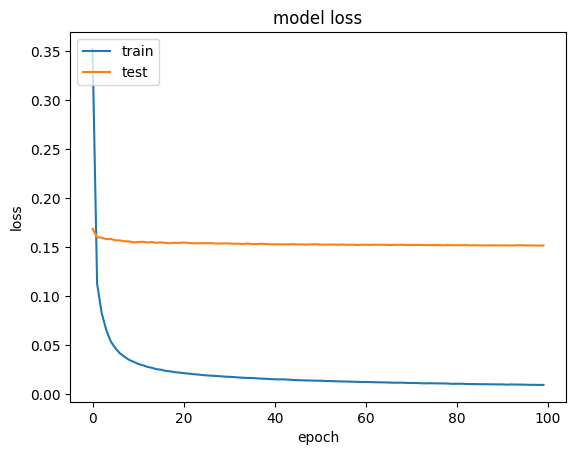

In [58]:
plt.plot(history_comb.history['loss'])
plt.plot(history_comb.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()